In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "latest") \
  .option("subscribe", "stock-trades") \
  .load()

In [4]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrade_view") \
    .start()

In [6]:
clear_output(wait=True)

In [7]:
time.sleep(10)

In [8]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM raw_stocktrade_view').show(20))
time.sleep(1)

+----------------+--------------------+------------+---------+------+--------------------+-------------+
|             key|               value|       topic|partition|offset|           timestamp|timestampType|
+----------------+--------------------+------------+---------+------+--------------------+-------------+
|[5A 56 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|169773|2021-06-06 14:02:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|169774|2021-06-06 14:02:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|169775|2021-06-06 14:02:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|169776|2021-06-06 14:02:...|            0|
|[5A 58 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|169777|2021-06-06 14:02:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|169778|2021-06-06 14:02:...|            0|
|[5A 58 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|   

None

In [9]:
time.sleep(1)

In [10]:
raw_stream.stop()

In [11]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
    .withColumn("value", stream_df["value"].cast(StringType()))

In [12]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrade_view") \
    .start()

In [13]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM string_stocktrade_view').show(20, False))
time.sleep(1)

+---+-----+-----+---------+------+---------+-------------+
|key|value|topic|partition|offset|timestamp|timestampType|
+---+-----+-----+---------+------+---------+-------------+
+---+-----+-----+---------+------+---------+-------------+



None

In [14]:
string_stream.stop()

In [15]:
schema_stocktrade = StructType([
    StructField('payload', StructType([
        StructField("side", StringType(),  True),
        StructField("quantity", IntegerType(), True),
        StructField("symbol", StringType(),  True),
        StructField("price", IntegerType(),  True),
        StructField("account", StringType(),  True),
        StructField("userid", StringType(),  True)      
    ]))
])

In [16]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrade))

In [17]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- payload: struct (nullable = true)
 |    |    |-- side: string (nullable = true)
 |    |    |-- quantity: integer (nullable = true)
 |    |    |-- symbol: string (nullable = true)
 |    |    |-- price: integer (nullable = true)
 |    |    |-- account: string (nullable = true)
 |    |    |-- userid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [18]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stock_view") \
    .start()

In [19]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stock_view').show(20))
time.sleep(1)

+---+-----+-----+---------+------+---------+-------------+
|key|value|topic|partition|offset|timestamp|timestampType|
+---+-----+-----+---------+------+---------+-------------+
+---+-----+-----+---------+------+---------+-------------+



None

In [20]:
json_stream.stop()

In [21]:
stocktrade_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.payload.account", \
        "value.payload.symbol", \
        "value.payload.side", \
        "value.payload.price", \
        "value.payload.quantity", \
        "value.payload.userid"
    )

In [22]:
stocktrade_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- account: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- side: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- userid: string (nullable = true)



In [23]:
stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()

In [24]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view').show(20))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZTEST|stock-trades|2021-06-06 14:03:...| LMN456| ZTEST| BUY|  217|     870|User_7|
|    ZTEST|stock-trades|2021-06-06 14:03:...| ABC123| ZTEST|SELL|  440|     864|User_4|
|    ZJZZT|stock-trades|2021-06-06 14:03:...| ABC123| ZJZZT| BUY|  239|    3869|User_6|
|      ZVV|stock-trades|2021-06-06 14:03:...| LMN456|   ZVV| BUY|  835|     920|User_3|
|    ZJZZT|stock-trades|2021-06-06 14:03:...| ABC123| ZJZZT| BUY|  581|    1079|User_7|
|    ZVZZT|stock-trades|2021-06-06 14:03:...| XYZ789| ZVZZT|SELL|  196|    3682|User_1|
|    ZXZZT|stock-trades|2021-06-06 14:03:...| LMN456| ZXZZT| BUY|  672|    4883|User_7|
|    ZJZZT|stock-trades|2021-06-06 14:03:...| LMN456| ZJZZT| BUY|  912|    1327|User_9|
|      ZVV|stock-trades|2021-06-

None

In [25]:
clear_output(wait=True)
display(spark.sql('SELECT event_key, COUNT(1) AS count, round(mean(price),0) as price, round(mean(quantity),0) as qty FROM stocktrade_view GROUP BY 1').show(20))
time.sleep(1)

+---------+-----+-----+------+
|event_key|count|price|   qty|
+---------+-----+-----+------+
|    ZXZZT|   65|490.0|2609.0|
|    ZVZZT|   60|519.0|2374.0|
|    ZTEST|   51|445.0|2295.0|
|    ZWZZT|   66|506.0|2397.0|
|    ZJZZT|   60|544.0|2476.0|
|      ZVV|   50|468.0|2446.0|
|     ZBZX|   59|502.0|2416.0|
+---------+-----+-----+------+



None

In [29]:
stocktrade_stream.stop()

In [63]:
window_duration = '60 seconds'
slide_duration = '10 seconds'

In [64]:
windowed_count_df = stocktrade_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(F.window(stocktrade_stream_df.event_timestamp, window_duration, slide_duration), stocktrade_stream_df.symbol) \
    .count()

In [85]:
count_stream = windowed_count_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("count_view") \
    .start()

In [86]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM count_view LIMIT 20').show())
    time.sleep(1)

+--------------------+------+-----+
|              window|symbol|count|
+--------------------+------+-----+
|{2021-06-06 11:50...| ZTEST|   30|
|{2021-06-06 11:51...| ZWZZT|   26|
|{2021-06-06 11:50...| ZTEST|   30|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:51...|  ZBZX|   21|
|{2021-06-06 11:50...| ZVZZT|   35|
|{2021-06-06 11:50...| ZJZZT|   39|
|{2021-06-06 11:50...| ZVZZT|   35|
|{2021-06-06 11:50...| ZTEST|   12|
|{2021-06-06 11:50...| ZXZZT|   16|
|{2021-06-06 11:50...| ZWZZT|   32|
|{2021-06-06 11:51...|   ZVV|   31|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...| ZWZZT|   32|
|{2021-06-06 11:50...| ZXZZT|   52|
|{2021-06-06 11:50...| ZVZZT|   10|
|{2021-06-06 11:50...|   ZVV|   43|
|{2021-06-06 11:50...| ZVZZT|   35|
+--------------------+------+-----+



None

KeyboardInterrupt: 

In [67]:
count_stream.stop()

In [35]:
########################
# Visualisations
########################
# Graphing real-time data
# loading packages
import time
import random as rd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# sample data from stocktrade_view
x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 2000''')
x_y_df = x_y.toPandas()
x_y_df

,event_key,event_topic,event_timestamp,account,symbol,side,price,quantity,userid
0,ZXZZT,stock-trades,2021-06-06 14:13:52.849,XYZ789,ZXZZT,BUY,861,1891,User_6
1,ZVV,stock-trades,2021-06-06 14:13:52.773,LMN456,ZVV,SELL,266,3356,User_8
2,ZVZZT,stock-trades,2021-06-06 14:13:52.737,ABC123,ZVZZT,SELL,168,2679,User_5
3,ZVZZT,stock-trades,2021-06-06 14:13:52.659,ABC123,ZVZZT,BUY,700,3978,User_7
4,ZWZZT,stock-trades,2021-06-06 14:13:52.584,LMN456,ZWZZT,BUY,302,1582,User_9
...,...,...,...,...,...,...,...,...,...
822,ZBZX,stock-trades,2021-06-06 14:13:12.380,LMN456,ZBZX,BUY,786,2928,User_6
823,ZWZZT,stock-trades,2021-06-06 14:13:12.323,XYZ789,ZWZZT,SELL,468,2595,User_5
824,ZXZZT,stock-trades,2021-06-06 14:13:12.307,XYZ789,ZXZZT,BUY,414,2744,User_8
825,ZJZZT,stock-trades,2021-06-06 14:13:12.226,XYZ789,ZJZZT,SELL,912,768,User_2


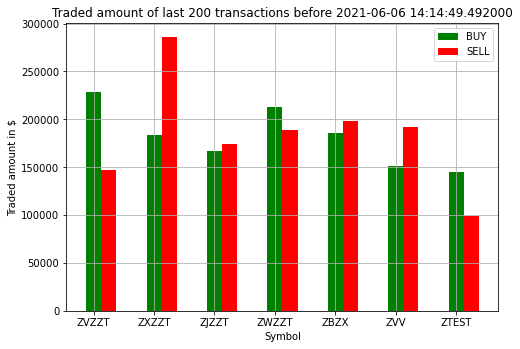

KeyboardInterrupt: 

In [36]:
stocktrade_stream.stop()
# Plotting tranded amount vs stock (symbol)
# taking the most recent 200 transactions
x_y = spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol
                        ''')
x_y_df = x_y.toPandas()
# sorting values by 2 columns
x_y_df = x_y_df.sort_values(by = ['symbol', 'side'])
print(x_y_df)


def live_bar_plot(df, figsize=(7,5), title = 'Traded amount of last 200 transactions'):
    clear_output(wait=True)
    labels = list(df.symbol.unique())

    data = [ df[df['side'] == 'BUY']['traded_amount_in_dollars']
            ,df[df['side'] == 'SELL']['traded_amount_in_dollars']
           ]
    X = np.arange(len(df.symbol.unique()))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
    ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
    ax.legend(labels=['BUY', 'SELL'])
    ax.set_xticks(X)
    ax.set_xticklabels(labels)


    plt.title(title)
    plt.grid(True)
    plt.xlabel('Symbol')
    plt.ylabel('Traded amount in $')
    plt.show();

stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()    



while True:
    x_y= spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                        , max(event_timestamp) as max_event_timestamp
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol
                    ''')
    
    x_y_df = x_y.toPandas()
    
    if x_y_df.shape[0] > 0:
        # sorting values by 2 columns
        x_y_df = x_y_df.sort_values(by = ['symbol', 'side'])

        x_y_df = x_y.toPandas()
        print(x_y_df)  

        live_bar_plot(x_y_df, title = f'Traded amount of last 200 transactions before {max(x_y_df.max_event_timestamp)}') 

    # updating every 10 s
    time.sleep(10)

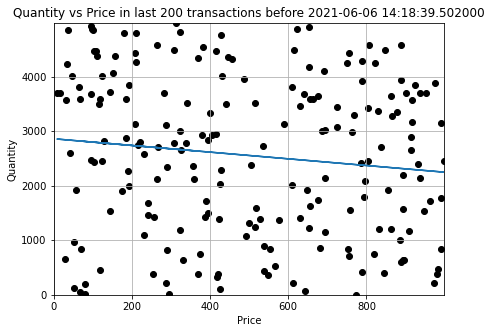

KeyboardInterrupt: 

In [37]:
def live_scatter_plot(x, y, figsize=(7,5), title='Testing Update'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.xlim(0, max(x))
    plt.ylim(0, max(y))
    x= [float(i) for i in x]
    y= [float(i) for i in y]

    if len(x) > 1:
        plt.scatter(x,y, label='axis y', color='k')
        # printing line of best fit
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, [x * m for x in x] + b)

    plt.title(title)
    plt.grid(True)
    plt.xlabel('Price')
    plt.ylabel('Quantity')
    plt.show();


while True: 
    x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 200''')
    x_y_df = x_y.toPandas()
    print(x_y_df)  
    live_scatter_plot(x_y_df.price, x_y_df.quantity, title = f'Quantity vs Price in last 200 transactions before {max(x_y_df.event_timestamp)}') 
    time.sleep(10)

In [ ]:
# Build Spark Query 2 using view "stocktraide_view" - order by timestamp

In [72]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view order by event_timestamp desc').show(15))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZWZZT|stock-trades|2021-06-06 11:48:...| XYZ789| ZWZZT| BUY|   41|    3964|User_7|
|    ZVZZT|stock-trades|2021-06-06 11:48:...| ABC123| ZVZZT|SELL|  329|    4407|User_7|
|    ZJZZT|stock-trades|2021-06-06 11:48:...| ABC123| ZJZZT| BUY|  188|    2529|User_2|
|    ZXZZT|stock-trades|2021-06-06 11:48:...| ABC123| ZXZZT|SELL|  771|    1123|User_6|
|    ZTEST|stock-trades|2021-06-06 11:48:...| XYZ789| ZTEST| BUY|  965|    3562|User_6|
|    ZTEST|stock-trades|2021-06-06 11:48:...| XYZ789| ZTEST| BUY|  888|    2541|User_8|
|    ZJZZT|stock-trades|2021-06-06 11:48:...| XYZ789| ZJZZT|SELL|  960|    1508|User_5|
|    ZWZZT|stock-trades|2021-06-06 11:48:...| ABC123| ZWZZT| BUY|  227|    3603|User_3|
|    ZVZZT|stock-trades|2021-06-

None

In [69]:
# Export Query 2 to dataframe then parquet file

In [83]:
from pyspark import SparkFiles
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)
df = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp desc')

In [84]:
df.count()

155

In [ ]:
df.write.parquet('./query2_alldata.parquet',mode='append')

In [ ]:
# Read parquet file for visualisation and machine learning

In [36]:
query2_df = sqlContext.read.parquet('./query_alldata.parquet')
query2_df.show(20)

+---------+------------+--------------------+------+-------+------+----+--------+-----+
|event_key| event_topic|     event_timestamp|userid|account|symbol|side|quantity|price|
+---------+------------+--------------------+------+-------+------+----+--------+-----+
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_5| ABC123| ZVZZT|SELL|    1401|  287|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_3| LMN456| ZVZZT|SELL|     935|   98|
|     ZBZX|stock-trades|2021-06-06 03:06:...|User_1| LMN456|  ZBZX| BUY|    1795|  306|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_2| LMN456|   ZVV| BUY|    1220|  106|
|    ZJZZT|stock-trades|2021-06-06 03:06:...|User_4| XYZ789| ZJZZT|SELL|     189|  522|
|    ZXZZT|stock-trades|2021-06-06 03:06:...|User_7| ABC123| ZXZZT| BUY|    3060|  545|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_1| XYZ789| ZVZZT|SELL|    3732|  757|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_8| XYZ789|   ZVV|SELL|    4210|  614|
|    ZWZZT|stock-trades|2021-06-